## ConvNet

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 *5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] #all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) #conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [20]:
##try the classifier
input = torch.randn(1, 1, 32, 32) ##32x32 images
out = net(input)
print(out)

tensor([[ 0.0044,  0.0796, -0.0305,  0.0813, -0.1115,  0.0182,  0.0118,
         -0.0547, -0.0706,  0.0831]])


In [21]:
net.zero_grad()
out.backward(torch.randn(1, 10), retain_graph=True) ##otherwise loss.backward() won't work

## Loss function

In [22]:
target = torch.arange(1, 11) ##dummy target
print(target)
target = target.view(1, -1) ##same shape as the output
print(target)
criterion = nn.MSELoss()

loss = criterion(out, target)
print(loss)

tensor([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])
tensor([[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]])
tensor(38.5463)


In [23]:
print(loss.grad_fn) #MSELoss
print(loss.grad_fn.next_functions[0][0]) #Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) #ReLU

## Backprop

In [24]:
net.zero_grad()
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([ 0.,  0.,  0.,  0.,  0.,  0.])
conv1.bias.grad after backward
tensor([ 0.0559, -0.0732,  0.1637,  0.0369, -0.0289, -0.0056])


## Update the weights

In [25]:
##update rule weight = weight - leaning_rate * gradient (Stochastic Gradient Descent)
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [26]:
##torch.optim implements all update rules
import torch.optim as optim

##create the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

##training loop
optimizer.zero_grad() ##gradient manually set to zero
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() ##does the update

In [28]:
print(loss)

tensor(37.6969)


## Data loaders and transformers
CIFAR10 dataset, images of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

1) __Loading and normalizing CIFAR10__

In [29]:
import torchvision
import torchvision.transforms as transforms

In [30]:
##Tensors of normalized range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


 frog truck truck  deer


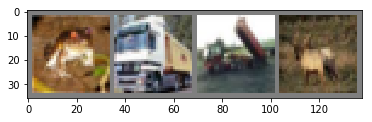

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 ##unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2) __Define a Convolution Neural Network__

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 *5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

3) __Define a Loss function and optimizer__

In [36]:
##classification cross-entropy loss and sgd with momentum (optimizer)
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4) __Train the network__

In [37]:
##network training
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        #forward+backward+optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: #print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.227
[1,  4000] loss: 1.949
[1,  6000] loss: 1.719
[1,  8000] loss: 1.569
[1, 10000] loss: 1.545
[1, 12000] loss: 1.480
[2,  2000] loss: 1.398
[2,  4000] loss: 1.374
[2,  6000] loss: 1.323
[2,  8000] loss: 1.274
[2, 10000] loss: 1.295
[2, 12000] loss: 1.244
Finished Training


5) __Test the network on the test data__

GroundTruth:    cat  ship  ship plane


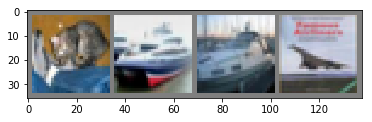

In [38]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [39]:
outputs = net(images)

In [40]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [41]:
##performance on the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [42]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 77 %
Accuracy of  bird : 42 %
Accuracy of   cat : 56 %
Accuracy of  deer : 42 %
Accuracy of   dog : 37 %
Accuracy of  frog : 60 %
Accuracy of horse : 72 %
Accuracy of  ship : 77 %
Accuracy of truck : 60 %


## Training on GPU

In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [5]:
net.to(device)

NameError: name 'net' is not defined

In [47]:
inputs, labels = inputs.to(device), labels.to(device)

PyTorch will use one GPU by default